# How to Analyse the 21cm Data from the 20m Observations

* First download the file which is lined under "On/Off cal" under the "Spectra" section of your data page
* Then upload this file into the Jupyter Hub
* Use the code below to read in your file

In [1]:
#It's good practice in coding to keep all your input statements at the top of the code/notebook. 
#You need to run this before the code below will run
 
#Import numpy (lots of useful math stuff)
import numpy as np

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Astropy file input/output help
from astropy.io import ascii

#Astropy model fitting
from astropy.modeling import models, fitting

In [2]:
t = ascii.read("Skynet_58800_messier_31_43924_53537.A.onoff.cal.txt")
t

col1,col2,col3,col4,col5,col6
float64,float64,float64,float64,float64,float64
1428.9143,0.2346,-0.0424,1397.6643,0.1023,-0.0817
1428.89904,0.1912,-0.0514,1397.64904,0.0484,-0.0685
1428.88378,0.2317,-0.0391,1397.63378,0.1432,-0.0094
1428.86853,0.2207,-0.0218,1397.61853,0.0786,-0.0522
1428.85327,0.1968,-0.0951,1397.60327,0.0477,-0.0483
1428.83801,0.288,-0.0045,1397.58801,0.1128,-0.046
1428.82275,0.1664,-0.0439,1397.57275,0.0185,-0.0316
1428.80749,0.2118,-0.0146,1397.55749,0.0408,-0.0538
1428.79223,0.1725,-0.0628,1397.54223,0.0937,-0.0524


Most of you will have the actual data in columns 1 and 2. Here is an example of me plotting that for my data (M31) and adjusting the x and y limits to show the data. Most of you have much more distant galaxies than M31, so your signal will be weaker. Let me know if you need help finding it. 

Text(0,0.5,'Flux (Kelvin)')

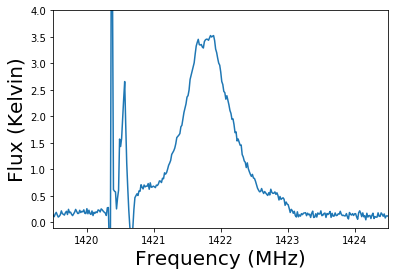

In [3]:
freq = t['col1']
flux = t['col2']

plt.plot(freq,flux) 
plt.xlim(1419.5,1424.5)
plt.ylim(-0.1,4)
plt.xlabel("Frequency (MHz)", fontsize=20)
plt.ylabel("Flux (Kelvin)", fontsize=20)

## Initial Measurements ##

I used the "live spectrum" viewer of the 20m to measure the values of the middle and two sides of the profile as 
* middle: 1421.778 MHz
* low freq side: 1421.414 MHz (roughly at the 50% flux point)
* high freq side: 1422.233 MHz
(you can do this in python if you wish, but no need to). 

This gave a redshift of z=-0.00096, or v = -287 km/s (M31 is coming towards us!), and a width of DeltaF = 819 kHz, or W = 173 km/s. 

Now to measure the area under the curve I need to use the data read in here. 

First I will convert the fluxes to units of Jy and the x-axis to units of km/s (see the Observing Lab instructions for where these conversions come from - note you can either convert the data then calculate the area, or calculate the area and do a unit conversion. Either way works fine!). 

        col1       
-------------------
 -1796.164487718288
-1792.9414746446603
-1789.7184615708993
-1786.4975605634604
-1783.2745474898327
-1780.0515344160717
 -1776.828521342444
 -1773.605508268683
-1770.3824951950553
-1767.1594821212943
                ...
 1136.5450820537749
 1139.7680951275024
 1142.9889961349415
 1146.2120092086025
 1149.4350222823302
 1152.6580353559912
  1155.881048429719
 1159.1040615033799
 1162.3270745771074
 1165.5500876507685
 1168.7709886582077
Length = 921 rows         col2        
--------------------
   6.251019108280254
  5.0946072186836515
   6.173747346072187
  5.8806475583864115
   5.243821656050955
    7.67388535031847
  4.4338004246284495
   5.643503184713376
   4.596337579617834
   6.344278131634819
                 ...
  0.6155095541401273
  1.2789808917197452
-0.07194267515923568
 0.46629511677282376
 0.49826963906581745
0.005329087048832272
   1.236348195329087
 -0.1119108280254777
   3.650424628450106
  1.2097027600849257
  0.325074309978768

Text(0,0.5,'Flux (Jy)')

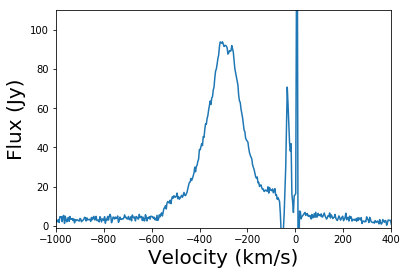

In [4]:
vel = 3e5*(1-t['col1']/1420.41)
flux = 2761*t['col2']/(314*0.33)

print(vel,flux)

plt.plot(vel,flux) 
plt.xlim(-1000,400)
plt.ylim(-1,110)
plt.xlabel("Velocity (km/s)", fontsize=20)
plt.ylabel("Flux (Jy)", fontsize=20)

Now if I just sum up the area under the curve between say -600 and -150 km/s I would get almost the right answer, but really I want to know how much the bump goes above the baseline (the trend either side). So I really need to fit that trend and calculate the area between it and the top of the bump.

I'll start by trimming the data to just be this narrow bit around the width.

In [5]:
flux=flux[vel>-1000]
vel=vel[vel>-1000]
flux=flux[vel<200]
vel=vel[vel<200]

Now I want to remove the actual signal to find the bit to fit too..... By plotting it I can see anything where the flux>7, or <0 is signal (either from M31, or the Milky Way). 

Text(0,0.5,'Flux (Jy)')

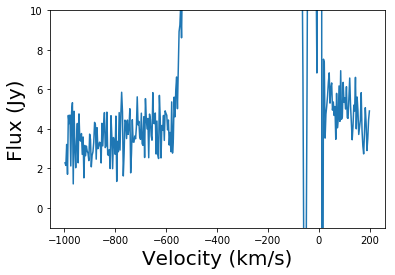

In [6]:
plt.plot(vel,flux) 
plt.ylim(-1,10)
plt.xlabel("Velocity (km/s)", fontsize=20)
plt.ylabel("Flux (Jy)", fontsize=20)

In [7]:
velfit=vel[flux<7]
fluxfit=flux[flux<7]
velfit=velfit[fluxfit>0]
fluxfit=fluxfit[fluxfit>0]
#print(fluxfit,velfit)

Text(0,0.5,'Flux (Jy)')

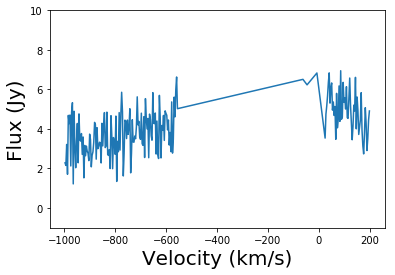

In [8]:
plt.plot(velfit,fluxfit) 
plt.ylim(-1,10)
plt.xlabel("Velocity (km/s)", fontsize=20)
plt.ylabel("Flux (Jy)", fontsize=20)

Now we just fit a polynominal to that using the astropy routine we used in a HW. We might need not just a line fit - I'm going to try a 3rd order polynomial. 

In [9]:
#Use a linar model (straightline fit). The intercept should be 0,0 (the position of the Sun!)
model = models.Polynomial1D(1)
#Use linear least squares fitting
fitter = fitting.LinearLSQFitter()

best_fit = fitter(model, velfit, fluxfit)
print(best_fit)


Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                  c1         
    ----------------- ---------------------
    4.855036189915044 0.0015184855082825343


Text(0,0.5,'Flux (Jy)')

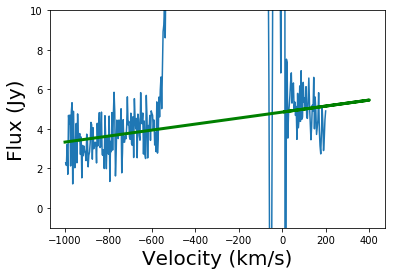

In [10]:
velplot=[-1000,400,10]
fit=best_fit(velplot)
plt.plot(vel,flux) 
plt.ylim(-1,10)
plt.plot(velplot, fit, color='g', linewidth=3,label='Best Fit')
plt.xlabel("Velocity (km/s)", fontsize=20)
plt.ylabel("Flux (Jy)", fontsize=20)


Now subtract this "baseline" from the data. The peak should rise up from zero (added with the red line below).

Text(0,0.5,'Flux (Jy)')

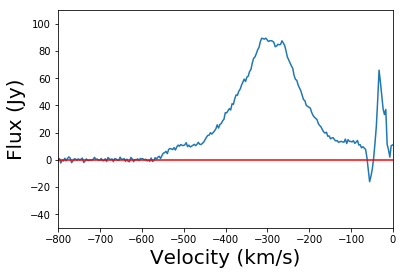

In [11]:
fluxcor=flux-best_fit(vel)
plt.plot(vel,fluxcor) 
plt.xlim(-800,0)
plt.ylim(-50,110)
plt.plot([-1000,400],[0,0],'r')
plt.xlabel("Velocity (km/s)", fontsize=20)
plt.ylabel("Flux (Jy)", fontsize=20)

Now we just add up the area under the curve. I'm going to chose to do it between -600 and -100 km/s so I don't get MW flux

The "channel width" (spacing between measurements in freq) is 15.26 kHz, or 3.22km/s (can see this from the header, or look at the data, so need to multiply the sum of the values by this to get the total area in Jy km/s. 

In [17]:
fluxadd=fluxcor[vel>-600]
fluxadd=fluxcor[vel<-100]
area=sum(fluxadd)* 3.22
print('The measured HI flux is then: ', area, 'this is in Jy km/s')

The measured HI flux is then:  17332.289528032135 this is in Jy km/s


This is just one polarization (half the total flux), so multiply by two, and finally the HI mass is given by: 

In [19]:
totalflux = 2*area
print('The total HI flux is then: ', totalflux, 'this is in Jy km/s')
d = 0.77 #Distance to M31 in Mpc from the table
HImass = 2.36e5*2*area*d**2
print('The HI mass in solar masses is: ', HImass)

The total HI flux is then:  34664.57905606427 this is in Jy km/s
The HI mass in solar masses is:  4850420425.672359
